[Chris McCormick  BERT Word Embeddings Tutorial](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)
[Visualizing BERT](https://home.ttic.edu/~kgimpel/viz-bert/viz-bert.html#:~:text=This%20page%20hosts%20a%20Jupyter%20Notebook%20for%20creating,a%20file%20with%20sentences%20containing%20a%20given%20word.)

In [1]:
import os.path as path
import numpy as np
import pickle
from matplotlib import pyplot as plt

from sklearn.manifold import TSNE

import torch
from szx81.data.dataset import Dataset
from torch.utils.data import DataLoader

import szx81.core.tools as tools
from szx81.core.tools import md
from szx81.tokenizer.tokenizer import Tokenizer
from szx81.models.bert_rv.data import Data
import szx82.models.bert.pre.train as train
import szx82.models.bert.pre.model as model

In [2]:
import importlib
importlib.reload(model)

<module 'szx82.models.bert.pre.model' from 'G:\\My Drive\\workplaces\\szx82\\src\\szx82\\models\\bert\\pre\\model.py'>

In [3]:
PROJECT_PREPEND = '_half'
DATA_STORE1 = 'C:/Users/stefa/Documents/workspaces/szx81/EURUSD/data_store'
DATA_STORE = 'G:/My Drive/workplaces/szx81/EURUSD/data_store'
DATA_NAME = 'tokenizer_piecewise_short;mean_len-15;seg_size-10;idx_step-1;level-4;'
'tokenizer_piecewise_short;mean_len-15;seg_size-10;idx_step-1;level-4;.pkl'
TOKEN_FILE = DATA_NAME + '.pkl'
DATA_FILE = 'data_' + DATA_NAME + '.pkl'

PROJECT_NAME_BASE = 'BERT_PRE_bert'

In [11]:
with open(path.join(DATA_STORE1, TOKEN_FILE), 'rb') as f: 
            TOKENIZER = pickle.load(f)

data = train.data(path.join(DATA_STORE, DATA_FILE))

TRAIN_DATASET = Dataset(data['train_data']) 
VAL_DATASET = Dataset(data['val_data']) 
TEST_DATASET = Dataset(data['test_data'])
PARAMETERS = data['parameters']
TOKENIZER.add_to_vocab(PARAMETERS['pred_list'])
vocab_hash = TOKENIZER.vocab_hash()
assert vocab_hash == PARAMETERS['vocab_hash'] 

In [6]:
def _():
    model_path = path.join(DATA_STORE, DATA_NAME, PROJECT_NAME_BASE + PROJECT_PREPEND, PROJECT_NAME_BASE + PROJECT_PREPEND + '_bst_.pt')
    if not path.exists(model_path):
        print(f"path: '{model_path}' does not exist")
        return

    return model.model_factory(model_path)
 
MODEL = _()                          
assert MODEL.config.vocab == TOKENIZER.vocab_hash()

In [ ]:

MASK_IDS = TOKENIZER.convert_tokens_to_ids(TOKENIZER.MASK)
PAD_IDS = TOKENIZER.convert_tokens_to_ids(TOKENIZER.PAD)

def _(hdn_st_idx=-1, sle=slice(0), count=10):
     
    test_dataloader = DataLoader(
                        TEST_DATASET,
                        batch_size=1, 
                        shuffle=True, 
                        pin_memory=False,
                        drop_last=True,)
    sqc_emb = []
    virtual = []
    direction = []

    for _ in range(count):
        batch = next(iter(test_dataloader))
        
        input_ids = batch['input']['input_ids']
        labels = batch['input']['labels']    
        mask_token_index = (input_ids == MASK_IDS).nonzero(as_tuple=True)
        input_ids[mask_token_index] = labels[mask_token_index]
        input_ids[:,:12]
        snd_stc_mask = batch['input']['token_type_ids'].nonzero(as_tuple=True)
        input_ids[snd_stc_mask] = PAD_IDS

        virtual.append(
            TOKENIZER.convert_ids_to_tokens
                                        (batch['admin']['pred_token']).item())
        direction.append(batch['admin']['direction'].item())
        input_ids[0][-2] = MASK_IDS
        with torch.no_grad():
            model_out = MODEL(
                        output_hidden_states=True, 
                        return_dict=True,
                        **batch['input']
                    )
        # sequence embedding : a simple approach is to average the second to last hidden layer of each token
        hidden_states = model_out.hidden_states
        sqc_emb.append(torch.mean(
                            hidden_states[hdn_st_idx][0][sle], dim=1))

    return {'virtual': virtual, 'direction': direction}, \
    {'sqc_emb': np.array(sqc_emb), 'sqc_emb_label': virtual}

VIRTUAL, SEQ_EMB, = _(-2, slice(-4), 5000)

In [40]:
def _():
    seq_emb_tsne = TSNE(n_components=2, early_exaggeration=12, verbose=0,
        metric='euclidean', init='pca', max_iter=2500)\
                                .fit_transform(SEQ_EMB['sqc_emb'])

    c = np.array([PARAMETERS['pred_token_map'][_] for _ in SEQ_EMB['sqc_emb_label']])
    xy = seq_emb_tsne.T
    xyc = np.vstack((xy, c))
    return xyc

SEQ_EMB_TSNE = _()

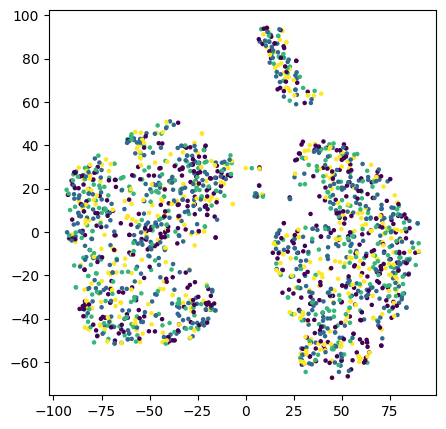

In [41]:
def _(xyc):
    mask = (xyc[2] > 3).nonzero()
    xyc = xyc.T[mask].T
    fig_name = 'sequence embeding'
    plt.close(fig_name)
    fig = plt.figure(num=fig_name, figsize=(5, 5), dpi=100, 
                        facecolor='white', edgecolor='black')
    ax = fig.add_subplot(111)
    ax.scatter(xyc[0], xyc[1], s=5, c=xyc[2], cmap='viridis', alpha=1)
    plt.show()

_(SEQ_EMB_TSNE)

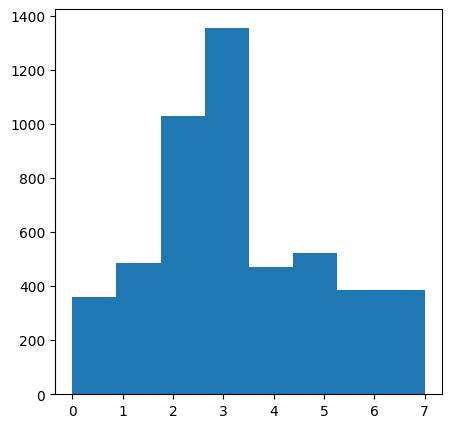

In [16]:
def _():
    SEQ_EMB['sqc_emb_label'][:10]
    # DATA_OBJECT.vp_tokenizer.token_map 
    xxx = [PARAMETERS['pred_token_map'][_] \
                        for _ in SEQ_EMB['sqc_emb_label']]
    
    fig_name = 'virtual label distribution'
    plt.close(fig_name)
    fig = plt.figure(num=fig_name, figsize=(5, 5), dpi=100, 
                        facecolor='white', edgecolor='black')
    ax = fig.add_subplot(111)
    ax.hist(xxx, bins=len(PARAMETERS['pred_token_map']))
    plt.show()

_()




```
MODEL.config.num_attention_heads: 6
len(model_out.attentions): 6
model_out.attentions[0].shape: torch.Size([100, 6, 23, 23])
```
Maximal token sequence length is `MODEL.config.max_position_embeddings`.<br>Attention table shape is (`batch size`, 2, `max_position_embeddings`,<br>`max_position_embeddings`) The dimension `2` is for `key, query` pairs.<br>



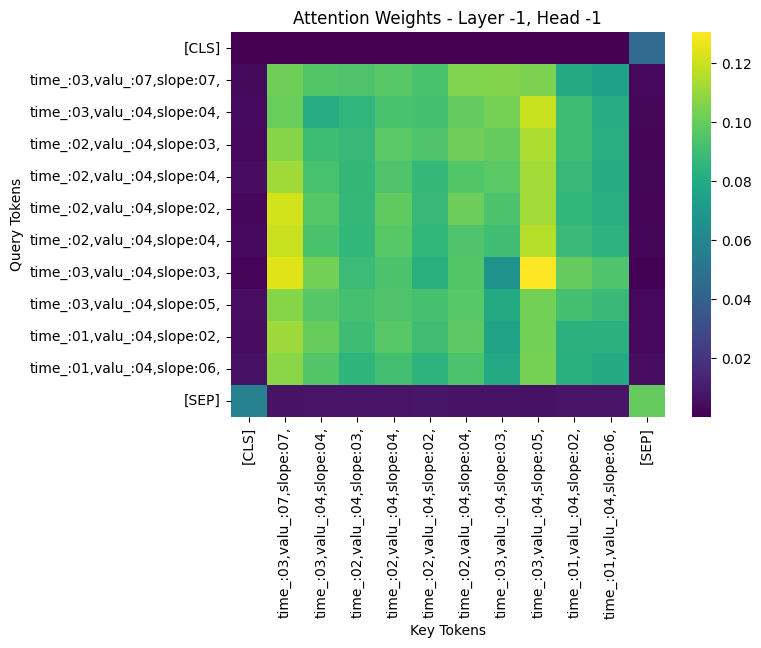

In [39]:
import seaborn as sns

def _(head=-1, layer=-1, count=100):

    # MODEL.config.attn_implementation="eager"
    MODEL.config.attn_implementation="default"

    test_dataloader = DataLoader(
        TEST_DATASET,
        batch_size=count,  # len(DATA_OBJECT.test_dataset),
        shuffle=True,
        pin_memory=False,
        drop_last=True,
    )

    batch = next(iter(test_dataloader))
    input_ids = batch["input"]["input_ids"]
    labels = batch["input"]["labels"]
    mask_token_index = (input_ids == MASK_IDS).nonzero(as_tuple=True)
    input_ids[mask_token_index] = labels[mask_token_index]
    input_ids[:, :12]
    snd_stc_mask = batch["input"]["token_type_ids"].nonzero(as_tuple=True)
    input_ids[snd_stc_mask] = PAD_IDS

    with torch.no_grad():
        model_out = MODEL(
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True,
            **batch["input"],
        )
        # List of attention tensors (one per layer):
        attentions = model_out.attentions
        md(f'''
```
MODEL.config.num_attention_heads: {MODEL.config.num_attention_heads}
len(model_out.attentions): {len(attentions)}
model_out.attentions[0].shape: {attentions[0].shape}
```
Maximal token sequence length is `MODEL.config.max_position_embeddings`.
Attention table shape is (`batch size`, 2, `max_position_embeddings`, `max_position_embeddings`)
The dimension `2` is for `key, query` pairs.
''')
    # MODEL.config.num_hidden_layers

    # Select a specific layer and head for visualization
    # First layer
    # First attention head
    last = 12
    attention = attentions[layer][0, head].numpy()[:last, :last]
    # Shape: (seq_len, seq_len)

    # Tokenize input for labels
    tokens = TOKENIZER.convert_ids_to_tokens(
        batch["input"]["input_ids"][0].squeeze().tolist()
    )[:last]
    # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Plot attention heatmap
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis", cbar=True
    )
    plt.title(f"Attention Weights - Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()


_(head=-1, layer=-1, count=100)

In [ ]:
# def attention_vis():
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

def attention_vis(head=-1, layer=-1, count=100):

    test_dataloader = DataLoader(
                        PARAMETERS['pred_token_map'],
                        batch_size=len(PARAMETERS['pred_token_map']), 
                        shuffle=True, 
                        pin_memory=False,
                        drop_last=True,)



    batch = next(iter(test_dataloader))
    
    with torch.no_grad():
        model_out = MODEL(
                        output_hidden_states=True,
                        output_attentions=True,
                        return_dict=True,
                        **batch['input']
                    )

    attentions = model_out.attentions  # List of attention tensors (one per layer)
    # 

    # Select a specific layer and head for visualization
      # First layer
        # First attention head
    last = 28
    attention = attentions[layer][0, head].numpy()[-last:, -last:]
      # Shape: (seq_len, seq_len)

    # Tokenize input for labels
    tokens = TOKENIZER.convert_ids_to_tokens(batch['input']["input_ids"][0].squeeze().tolist())[-last:]
    # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Plot attention heatmap
    plt.figure(figsize=(7, 5))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, 
                cmap="viridis", cbar=True)
    plt.title(f"Attention Weights - Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

attention_vis()